# Step-size Methods vs Pulses & Runtime

Compares const, linesearch (Armijo), and adam under identical baseline, basis, and stopping.
Objective fixed: terminal. Artifacts saved under `artifacts/<run_name>/<method>/...`.
Figures added later.

In [1]:
# Imports
from pathlib import Path
import sys
import os

notebook_dir = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
if str(repo_root) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root))
os.chdir(repo_root)

from src import TimeGridSpec, PulseShapeSpec, BasisSpec


In [2]:
# Experiment configuration inputs
max_time_min = 5.0  # per optimizer runtime budget in minutes

omega_shape = {'kind': 'polynomial', 'area_pi': 1.0}
delta_shape = {'kind': 'linear_chirp', 'area_pi': 0.0, 'amplitude_scale': 40.0}
K_omega = 6
K_delta = 0

max_iters = 2000
grad_tol = 1e-7
rtol = 1e-7

const_learning_rate = 0.05
alpha0 = 1.0
ls_beta = 0.5
ls_sigma = 1e-8
ls_max_backtracks = 15
adam_learning_rate = 0.05
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

power_weight = 1.0e-4
neg_weight = 1.0
neg_kappa = 10.0

artifact_root = Path('./artifacts')
run_name = 'stepsize-comparison'
objective = 'terminal'


## Runner utilities

In [3]:

# Runner utilities
import csv
from pathlib import Path
from typing import Any, Dict

import numpy as np

from src import override_from_dict, run_experiment
from src.notebook_runners import (
    BaselineArrays,
    build_base_config,
    method_options,
    prepare_baseline,
)
from src.crab_notebook_utils import population_excited
from src.physics import propagate_piecewise_const

RUN_METHODS = ("const", "linesearch", "adam")


def extract_history_series(history: Dict[str, np.ndarray]) -> Dict[str, np.ndarray | None]:
    def _pull(key: str) -> np.ndarray | None:
        series = history.get(key)
        if series is None or len(series) == 0:
            return None
        return np.asarray(series, dtype=np.float64)

    return {
        "cost_total": _pull("total"),
        "cost_terminal": _pull("terminal"),
        "cost_power": _pull("power_penalty"),
        "cost_neg": _pull("neg_penalty"),
        "grad_norm": _pull("grad_norm"),
        "step_norm": _pull("step_norm"),
    }


def sum_oracle_calls(history: Dict[str, np.ndarray]) -> int:
    calls = history.get("calls_per_iter")
    if calls is None or len(calls) == 0:
        return 0
    return int(np.asarray(calls, dtype=np.int64).sum())


def compute_pulse_metrics(omega: np.ndarray, t_us: np.ndarray) -> Dict[str, float]:
    max_abs = float(np.max(np.abs(omega)))
    area = float(np.trapz(np.abs(omega), t_us) / np.pi)
    neg_frac = float(np.mean(omega < 0.0))
    return {
        "max_abs_omega": max_abs,
        "area_omega_over_pi": area,
        "negativity_fraction": neg_frac,
    }


def save_trajectories(
    run_dir: Path,
    t_us: np.ndarray,
    psi_path: np.ndarray,
    rho_path: np.ndarray,
    pop_excited: np.ndarray,
) -> None:
    traj_path = Path(run_dir) / "trajectories.npz"
    np.savez_compressed(
        traj_path,
        t_us=t_us,
        psi_path=psi_path,
        rho_path=rho_path,
        pop_excited=pop_excited,
    )


def build_method_payload(result, ctx: BaselineArrays) -> Dict[str, Any]:
    history_map = extract_history_series(result.history)
    oracle_calls = sum_oracle_calls(result.history)
    metrics = result.final_metrics
    runtime_s = float(metrics.get("runtime_s", np.nan))
    pulses = result.pulses
    omega_final = np.asarray(pulses["omega"], dtype=np.float64)
    delta_final_raw = pulses.get("delta")
    delta_final = (
        np.zeros_like(omega_final)
        if delta_final_raw is None
        else np.asarray(delta_final_raw, dtype=np.float64)
    )
    omega_init = np.asarray(
        pulses.get("omega_base", ctx.arrays["Omega0"]),
        dtype=np.float64,
    )
    delta_init_raw = pulses.get("delta_base", ctx.arrays.get("Delta0"))
    delta_init = (
        np.zeros_like(omega_final)
        if delta_init_raw is None
        else np.asarray(delta_init_raw, dtype=np.float64)
    )
    t_us = np.asarray(pulses.get("t_us", ctx.t_us), dtype=np.float64)
    traj = propagate_piecewise_const(
        omega_final,
        delta_final,
        float(ctx.dt_us),
        psi0=ctx.psi0,
    )
    rho_path = np.asarray(traj["rho_path"])
    psi_path = np.asarray(traj["psi_path"])
    pop_excited = population_excited(rho_path)
    save_trajectories(result.artifacts_dir, t_us, psi_path, rho_path, pop_excited)
    history_total = history_map["cost_total"]
    iterations = history_total.size if history_total is not None else 0
    grad_final = (
        float(history_map["grad_norm"][-1])
        if history_map["grad_norm"] is not None and history_map["grad_norm"].size
        else None
    )
    step_final = (
        float(history_map["step_norm"][-1])
        if history_map["step_norm"] is not None and history_map["step_norm"].size
        else None
    )
    pulse_metrics = compute_pulse_metrics(omega_final, t_us)
    raw_status = str(result.optimizer_state.get("status", "completed")).lower()
    status = "error" if "fail" in raw_status else "ok"
    return {
        "history": history_map,
        "oracle_calls": oracle_calls,
        "runtime_s": runtime_s,
        "final_pulses": {"omega": omega_final, "delta": delta_final},
        "initial_pulses": {"omega": omega_init, "delta": delta_init},
        "time_grid_us": t_us,
        "trajectories": {
            "psi_path": psi_path,
            "rho_path": rho_path,
            "pop_excited": pop_excited,
        },
        "metrics": {
            "total_final": float(metrics.get("total", np.nan)),
            "terminal_final": float(metrics.get("terminal", np.nan)),
            "power_final": float(metrics.get("power_penalty", 0.0)),
            "neg_final": float(metrics.get("neg_penalty", 0.0)),
            "iterations": iterations,
            "grad_norm_final": grad_final,
            "step_norm_final": step_final,
            **pulse_metrics,
        },
        "status": status,
        "status_detail": raw_status,
        "artifacts_dir": Path(result.artifacts_dir),
    }


def error_payload(message: str) -> Dict[str, Any]:
    nan = float("nan")
    empty_history = {
        "cost_total": None,
        "cost_terminal": None,
        "cost_power": None,
        "cost_neg": None,
        "grad_norm": None,
        "step_norm": None,
    }
    return {
        "history": empty_history,
        "oracle_calls": 0,
        "runtime_s": nan,
        "final_pulses": {"omega": None, "delta": None},
        "initial_pulses": {"omega": None, "delta": None},
        "time_grid_us": None,
        "trajectories": {
            "psi_path": None,
            "rho_path": None,
            "pop_excited": None,
        },
        "metrics": {
            "total_final": nan,
            "terminal_final": nan,
            "power_final": nan,
            "neg_final": nan,
            "iterations": 0,
            "grad_norm_final": None,
            "step_norm_final": None,
            "max_abs_omega": nan,
            "area_omega_over_pi": nan,
            "negativity_fraction": nan,
        },
        "status": "error",
        "status_detail": message,
        "artifacts_dir": None,
    }


## Run optimizers

In [4]:

# Run all (const, linesearch, adam)
time_grid_cfg = globals().get("time_grid_params")
runner_ctx = prepare_baseline(
    time_grid=time_grid_cfg,
    omega_shape=omega_shape,
    delta_shape=delta_shape,
    K_omega=K_omega,
    K_delta=K_delta,
    rho0=globals().get("rho0"),
    target=globals().get("target"),
    initial_omega=globals().get("initial_omega"),
    initial_delta=globals().get("initial_delta"),
)

penalties = {
    "power_weight": float(power_weight),
    "neg_weight": float(neg_weight),
    "neg_kappa": float(neg_kappa),
}
base_config, base_opts = build_base_config(
    runner_ctx.config,
    run_name=run_name,
    artifact_root=artifact_root,
    penalties=penalties,
    objective=objective,
    base_optimizer_options={
        "max_iters": int(max_iters),
        "grad_tol": float(grad_tol),
        "rtol": float(rtol),
        "max_time_s": float(max_time_min) * 60.0,
        "optimize_delta": bool(K_delta > 0),
    },
)

method_overrides = {
    "const": {"learning_rate": float(const_learning_rate)},
    "linesearch": {
        "alpha0": float(alpha0),
        "ls_beta": float(ls_beta),
        "ls_sigma": float(ls_sigma),
        "ls_max_backtracks": int(ls_max_backtracks),
    },
    "adam": {
        "learning_rate": float(adam_learning_rate),
        "beta1": float(beta1),
        "beta2": float(beta2),
        "epsilon": float(epsilon),
    },
}

results: Dict[str, Any] = {}

for method in RUN_METHODS:
    print(f"[{method}] starting optimization")
    method_payload: Dict[str, Any] | None = None
    try:
        overrides = method_overrides.get(method, {})
        opts = method_options(method, base_opts, overrides)
        config = override_from_dict(base_config, {"optimizer_options": opts})
        result = run_experiment(
            config,
            method=method,
            run_name=f"{run_name}-{method}",
            exist_ok=True,
        )
        method_payload = build_method_payload(result, runner_ctx)
        print(f"[{method}] finished optimization (status={method_payload['status']})")
    except Exception as exc:
        print(f"[{method}] error: {exc}")
        method_payload = error_payload(str(exc))
    results[method] = method_payload or error_payload("unavailable")


[const] starting optimization


C:\Users\yehon\AppData\Local\Temp\ipykernel_82160\3188715092.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(np.abs(omega), t_us) / np.pi)


[const] finished optimization (status=ok)
[linesearch] starting optimization
[linesearch] finished optimization (status=ok)
[adam] starting optimization
[adam] finished optimization (status=ok)


## Results summary

In [5]:
# Results summary (no plots)
if not results:
    raise RuntimeError("Run the optimizer cell first.")

header = (
    f"{'method':>10}  {'total':>12}  {'terminal':>12}  {'power':>10}  "
    f"{'neg':>10}  {'iters':>8}  {'runtime_s':>10}  {'oracle':>8}  "
    f"{'max|Omega|':>10}  {'area/pi':>10}  {'neg_frac':>10}"
)
print(header)
rows = []
for method in RUN_METHODS:
    data = results.get(method)
    if data is None:
        continue
    metrics = data["metrics"]
    row = {
        "method": method,
        "total_final": float(metrics["total_final"]),
        "terminal_final": float(metrics["terminal_final"]),
        "power_final": float(metrics["power_final"]),
        "neg_final": float(metrics["neg_final"]),
        "iterations": int(metrics["iterations"]),
        "runtime_s": float(data["runtime_s"]),
        "oracle_calls": int(data["oracle_calls"]),
        "max_abs_omega": float(metrics["max_abs_omega"]),
        "area_omega_over_pi": float(metrics["area_omega_over_pi"]),
        "negativity_fraction": float(metrics["negativity_fraction"]),
    }
    rows.append(row)
    line = (
        f"{method:>10}  {row['total_final']:12.5e}  {row['terminal_final']:12.5e}  "
        f"{row['power_final']:10.3e}  {row['neg_final']:10.3e}  {row['iterations']:8d}  "
        f"{row['runtime_s']:10.3f}  {row['oracle_calls']:8d}  {row['max_abs_omega']:10.3f}  "
        f"{row['area_omega_over_pi']:10.3f}  {row['negativity_fraction']:10.3f}"
    )
    print(line)

summary_fields = [
    "method",
    "total_final",
    "terminal_final",
    "power_final",
    "neg_final",
    "iterations",
    "runtime_s",
    "oracle_calls",
    "max_abs_omega",
    "area_omega_over_pi",
    "negativity_fraction",
]
summary_dir = (Path(artifact_root) / run_name).resolve()
summary_dir.mkdir(parents=True, exist_ok=True)
csv_path = summary_dir / "summary.csv"
with csv_path.open("w", newline="", encoding="utf-8") as fh:
    writer = csv.DictWriter(fh, fieldnames=summary_fields)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

print(f"Summary written to {csv_path}")


    method         total      terminal       power         neg     iters   runtime_s    oracle  max|Omega|     area/pi    neg_frac
     const   1.28199e-02   1.30362e-04   1.269e-02   9.609e-13       866      43.776       866      46.370       1.017       0.000
linesearch   1.35583e-02   1.19427e-03   1.236e-02   9.609e-13         2       0.203         3      45.844       1.001       0.000
      adam   1.15740e-02   4.37024e-05   1.153e-02   9.609e-13       197       9.926       197      41.813       1.035       0.000
Summary written to C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\artifacts\stepsize-comparison\summary.csv


## Figure Plan
- Cost vs iteration (log scale) for const, linesearch, adam.
- Cost-term breakdown (terminal, power, neg) vs iteration (log scale).
- Runtime (s) bar chart and oracle-call bar chart.
- Ω(t) and Δ(t) overlays: initial pulse plus finals (skip Δ if not optimised).
- Excited-state population vs time for each final control.
- Bloch-sphere trajectories: baseline and each method with instantaneous ground-state path.
- Save figures to rtifacts/<run_name>/figures/ with required filenames.


In [6]:

# Figure helpers
import json
from pathlib import Path
from typing import Any, Dict

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from src import ExperimentConfig
from src.physics import propagate_piecewise_const
from src.crab_notebook_utils import (
    population_excited,
    ground_state_projectors,
    bloch_coordinates,
)

METHOD_ORDER = ("const", "linesearch", "adam")
METHOD_COLORS = {
    "const": "#1f77b4",
    "linesearch": "#ff7f0e",
    "adam": "#2ca02c",
}
BASELINE_COLOR = "#555555"
FIG_FILES = {
    "cost": "fig_cost_vs_iter.png",
    "cost_terms": "fig_cost_terms_vs_iter.png",
    "runtime": "fig_runtime_bars.png",
    "oracle": "fig_oracle_calls.png",
    "omega": "fig_omega_overlay.png",
    "delta": "fig_delta_overlay.png",
    "population": "fig_population_vs_time.png",
    "bloch": "fig_bloch_trajectories.png",
}


def _rho_to_state(payload: Any) -> np.ndarray:
    arr = np.asarray(payload, dtype=np.complex128)
    if arr.shape == (2, 2):
        vals, vecs = np.linalg.eigh(arr)
        vec = vecs[:, int(np.argmax(vals))]
    else:
        vec = arr.reshape(2)
    phase = np.exp(-1j * np.angle(vec[0])) if abs(vec[0]) > 1e-12 else 1.0
    return (vec * phase).astype(np.complex128)


def ensure_results_loaded() -> Dict[str, Any]:
    global results
    if isinstance(globals().get("results"), dict) and results:
        return results
    root = Path(artifact_root)
    loaded: Dict[str, Any] = {}
    for method in METHOD_ORDER:
        mdir = root / f"{run_name}-{method}"
        if not mdir.exists():
            continue
        history_path = mdir / "history.npz"
        pulses_path = mdir / "pulses.npz"
        metrics_path = mdir / "metrics.json"
        config_path = mdir / "config.json"
        if not (history_path.exists() and pulses_path.exists() and metrics_path.exists()):
            continue
        history_npz = np.load(history_path)
        history = {k: history_npz[k] for k in history_npz.files}
        pulses_npz = np.load(pulses_path)
        metrics = json.loads(metrics_path.read_text(encoding="utf-8"))
        config = ExperimentConfig.from_dict(
            json.loads(config_path.read_text(encoding="utf-8"))
        )
        omega_final = np.asarray(pulses_npz["omega"], dtype=np.float64)
        delta_final = (
            np.asarray(pulses_npz["delta"], dtype=np.float64)
            if "delta" in pulses_npz
            else None
        )
        omega_init = np.asarray(pulses_npz["omega_base"], dtype=np.float64)
        delta_init = (
            np.asarray(pulses_npz.get("delta_base"), dtype=np.float64)
            if "delta_base" in pulses_npz
            else None
        )
        t_us = np.asarray(pulses_npz["t_us"], dtype=np.float64)
        traj_path = mdir / "trajectories.npz"
        if traj_path.exists():
            traj_npz = np.load(traj_path)
            trajectories = {
                "psi_path": traj_npz.get("psi_path"),
                "rho_path": traj_npz.get("rho_path"),
                "pop_excited": traj_npz.get("pop_excited"),
            }
        else:
            trajectories = {"psi_path": None, "rho_path": None, "pop_excited": None}
        calls = history.get("calls_per_iter")
        oracle_calls = int(np.asarray(calls, dtype=np.int64).sum()) if calls is not None else 0
        grad_hist = history.get("grad_norm")
        grad_final = float(grad_hist[-1]) if grad_hist is not None and grad_hist.size else None
        step_hist = history.get("step_norm")
        step_final = float(step_hist[-1]) if step_hist is not None and step_hist.size else None
        dt_us = float(np.mean(np.diff(t_us))) if t_us.size > 1 else 0.0
        power_final = float(metrics.get("power_penalty", 0.0))
        neg_final = float(metrics.get("neg_penalty", 0.0))
        total_final = float(metrics.get("total", metrics.get("total_cost", np.nan)))
        terminal_final = float(
            metrics.get("terminal", metrics.get("terminal_infidelity", np.nan))
        )
        area = float(np.trapz(np.abs(omega_final), t_us) / np.pi)
        neg_frac = float(np.mean(omega_final < 0.0))
        psi0 = _rho_to_state(config.baseline.params.get("rho0", [1.0, 0.0]))
        loaded[method] = {
            "history": {
                "cost_total": history.get("total"),
                "cost_terminal": history.get("terminal"),
                "cost_power": history.get("power_penalty"),
                "cost_neg": history.get("neg_penalty"),
                "grad_norm": history.get("grad_norm"),
                "step_norm": history.get("step_norm"),
            },
            "oracle_calls": oracle_calls,
            "runtime_s": float(metrics.get("runtime_s", np.nan)),
            "final_pulses": {"omega": omega_final, "delta": delta_final},
            "initial_pulses": {"omega": omega_init, "delta": delta_init},
            "time_grid_us": t_us,
            "dt_us": dt_us,
            "trajectories": trajectories,
            "metrics": {
                "total_final": total_final,
                "terminal_final": terminal_final,
                "power_final": power_final,
                "neg_final": neg_final,
                "iterations": int(history.get("total", np.array([])).size),
                "grad_norm_final": grad_final,
                "step_norm_final": step_final,
                "max_abs_omega": float(np.max(np.abs(omega_final))),
                "area_omega_over_pi": area,
                "negativity_fraction": neg_frac,
            },
            "status": metrics.get("status", "ok"),
            "artifacts_dir": mdir,
            "psi0": psi0,
        }
    globals()["results"] = loaded
    return loaded


def ensure_fig_dir() -> Path:
    run_dir = Path(artifact_root) / run_name
    fig_dir = run_dir / "figures"
    fig_dir.mkdir(parents=True, exist_ok=True)
    return fig_dir


def _series(arr: Any) -> np.ndarray | None:
    if arr is None:
        return None
    out = np.asarray(arr)
    return out if out.size else None


def plot_cost_vs_iter(results: Dict[str, Any], out_dir: Path) -> Path:
    fig, ax = plt.subplots(figsize=(6, 4))
    for method in METHOD_ORDER:
        payload = results.get(method)
        if not payload:
            continue
        series = _series(payload["history"].get("cost_total"))
        if series is None:
            continue
        iters = np.arange(1, series.size + 1)
        ax.plot(iters, series, label=method, color=METHOD_COLORS[method])
    ax.set_yscale("log")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Total cost")
    ax.set_title("Cost vs iteration")
    ax.grid(True, which="both", ls=":", alpha=0.5)
    ax.legend()
    fig.tight_layout()
    fig_path = out_dir / FIG_FILES["cost"]
    fig.savefig(fig_path, dpi=300)
    plt.show()
    return fig_path


def plot_cost_terms_vs_iter(results: Dict[str, Any], out_dir: Path) -> Path:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
    terms = [
        ("cost_terminal", "Terminal"),
        ("cost_power", "Power penalty"),
        ("cost_neg", "Neg penalty"),
    ]
    for ax, (key, title) in zip(axes, terms):
        for method in METHOD_ORDER:
            payload = results.get(method)
            if not payload:
                continue
            series = _series(payload["history"].get(key))
            if series is None:
                continue
            iters = np.arange(1, series.size + 1)
            ax.plot(iters, series, label=method, color=METHOD_COLORS[method])
        ax.set_yscale("log")
        ax.set_title(title)
        ax.grid(True, which="both", ls=":", alpha=0.5)
        ax.set_xlabel("Iteration")
    axes[0].set_ylabel("Cost component")
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig_path = out_dir / FIG_FILES["cost_terms"]
    fig.savefig(fig_path, dpi=300)
    plt.show()
    return fig_path


def plot_runtime_bars(results: Dict[str, Any], out_dir: Path) -> Path:
    fig, ax = plt.subplots(figsize=(6, 4))
    vals = [results.get(m, {}).get("runtime_s", np.nan) for m in METHOD_ORDER]
    ax.bar(METHOD_ORDER, vals, color=[METHOD_COLORS[m] for m in METHOD_ORDER])
    ax.set_ylabel("Runtime (s)")
    ax.set_title("Runtime comparison")
    ax.grid(True, axis="y", ls=":", alpha=0.5)
    fig.tight_layout()
    fig_path = out_dir / FIG_FILES["runtime"]
    fig.savefig(fig_path, dpi=300)
    plt.show()
    return fig_path


def plot_oracle_calls_bars(results: Dict[str, Any], out_dir: Path) -> Path:
    fig, ax = plt.subplots(figsize=(6, 4))
    vals = [results.get(m, {}).get("oracle_calls", 0) for m in METHOD_ORDER]
    ax.bar(METHOD_ORDER, vals, color=[METHOD_COLORS[m] for m in METHOD_ORDER])
    ax.set_ylabel("Oracle calls")
    ax.set_title("Oracle calls comparison")
    ax.grid(True, axis="y", ls=":", alpha=0.5)
    fig.tight_layout()
    fig_path = out_dir / FIG_FILES["oracle"]
    fig.savefig(fig_path, dpi=300)
    plt.show()
    return fig_path


def plot_pulses_overlay(
    results: Dict[str, Any],
    control: str,
    out_dir: Path,
    include_initial: bool = True,
) -> Path | None:
    fig, ax = plt.subplots(figsize=(8, 4))
    plotted = False
    for method in METHOD_ORDER:
        payload = results.get(method)
        if not payload:
            continue
        ctrl = payload.get("final_pulses", {}).get(control)
        if ctrl is None:
            continue
        t_us = payload.get("time_grid_us")
        ax.plot(t_us, ctrl, label=f"{method} final", color=METHOD_COLORS[method])
        plotted = True
    if include_initial:
        ref = next((results[m] for m in METHOD_ORDER if m in results), None)
        if ref:
            init = ref.get("initial_pulses", {}).get(control)
            if init is not None:
                t_us = ref.get("time_grid_us")
                ax.plot(t_us, init, label="initial", color=BASELINE_COLOR, ls="--")
                plotted = True
    if not plotted:
        plt.close(fig)
        print(f"[skip] No data for {control.upper()} overlay")
        return None
    ax.set_xlabel("Time (?s)")
    ax.set_ylabel(f"{control.upper()} (rad/?s)")
    title = "Omega overlay" if control == "omega" else "Delta overlay"
    ax.set_title(title)
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend()
    fig.tight_layout()
    fig_path = out_dir / FIG_FILES["omega" if control == "omega" else "delta"]
    fig.savefig(fig_path, dpi=300)
    plt.show()
    return fig_path


def ensure_trajectories(results: Dict[str, Any]) -> None:
    for method, payload in results.items():
        traj = payload.get("trajectories", {})
        rho_path = traj.get("rho_path") if traj else None
        if rho_path is not None and np.size(rho_path):
            continue
        pulses = payload.get("final_pulses", {})
        omega = pulses.get("omega")
        if omega is None:
            continue
        delta = pulses.get("delta")
        if delta is None:
            delta = np.zeros_like(omega)
        dt_us = payload.get("dt_us")
        if dt_us is None:
            t_us = payload.get("time_grid_us")
            dt_us = float(np.mean(np.diff(t_us))) if t_us is not None and t_us.size > 1 else 0.0
        psi0 = payload.get("psi0")
        if psi0 is None:
            psi0 = np.array([1.0, 0.0], dtype=np.complex128)
        prop = propagate_piecewise_const(omega, delta, dt_us, psi0=psi0)
        rho_path = prop["rho_path"]
        psi_path = prop["psi_path"]
        pop = population_excited(rho_path)
        payload.setdefault("trajectories", {})
        payload["trajectories"]["rho_path"] = rho_path
        payload["trajectories"]["psi_path"] = psi_path
        payload["trajectories"]["pop_excited"] = pop


def plot_population_vs_time(results: Dict[str, Any], out_dir: Path) -> Path | None:
    fig, ax = plt.subplots(figsize=(8, 4))
    plotted = False
    for method in METHOD_ORDER:
        payload = results.get(method)
        if not payload:
            continue
        traj = payload.get("trajectories", {})
        pop = traj.get("pop_excited")
        if pop is None:
            continue
        t_us = payload.get("time_grid_us")
        ax.plot(t_us, pop, label=method, color=METHOD_COLORS[method])
        plotted = True
    if not plotted:
        plt.close(fig)
        print("[skip] No population data available")
        return None
    ax.set_xlabel("Time (?s)")
    ax.set_ylabel("Excited-state population")
    ax.set_title("Population vs time")
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend()
    fig.tight_layout()
    fig_path = out_dir / FIG_FILES["population"]
    fig.savefig(fig_path, dpi=300)
    plt.show()
    return fig_path


def _sphere(ax) -> None:
    u = np.linspace(0, 2 * np.pi, 48)
    v = np.linspace(0, np.pi, 24)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, color="#dddddd", alpha=0.2, linewidth=0)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect((1, 1, 1))


def plot_bloch_trajectories(results: Dict[str, Any], out_dir: Path) -> Path | None:
    ref = next((results[m] for m in METHOD_ORDER if m in results), None)
    if ref is None:
        print("[skip] No data for Bloch trajectories")
        return None
    omega_base = ref["initial_pulses"]["omega"]
    delta_base = ref["initial_pulses"].get("delta")
    if delta_base is None:
        delta_base = np.zeros_like(omega_base)
    t_us = ref["time_grid_us"]
    dt_us = float(np.mean(np.diff(t_us))) if t_us.size > 1 else 0.0
    psi0 = ref.get("psi0")
    if psi0 is None:
        psi0 = np.array([1.0, 0.0], dtype=np.complex128)
    base_prop = propagate_piecewise_const(omega_base, delta_base, dt_us, psi0=psi0)
    base_coords = bloch_coordinates(base_prop["rho_path"])
    base_gs = bloch_coordinates(ground_state_projectors(omega_base, delta_base))
    panels = [("baseline", base_coords, base_gs, BASELINE_COLOR)]
    for method in METHOD_ORDER:
        payload = results.get(method)
        if not payload:
            continue
        rho_path = payload.get("trajectories", {}).get("rho_path")
        if rho_path is None:
            continue
        coords = bloch_coordinates(rho_path)
        omega = payload["final_pulses"]["omega"]
        delta = payload["final_pulses"].get("delta")
        if delta is None:
            delta = np.zeros_like(omega)
        gs = bloch_coordinates(ground_state_projectors(omega, delta))
        panels.append((method, coords, gs, METHOD_COLORS[method]))
    fig = plt.figure(figsize=(12, 10))
    axes = [fig.add_subplot(2, 2, idx + 1, projection="3d") for idx in range(len(panels))]
    for ax, (name, coords, gs, color) in zip(axes, panels):
        _sphere(ax)
        ax.plot(gs[:, 0], gs[:, 1], gs[:, 2], color="#7f7f7f", ls="--", label="GS")
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], color=color, label=name)
        ax.scatter(coords[0, 0], coords[0, 1], coords[0, 2], color=color, marker="o")
        ax.scatter(coords[-1, 0], coords[-1, 1], coords[-1, 2], color=color, marker="^")
        ax.set_title(name)
        ax.legend(loc="lower left")
    fig.tight_layout()
    fig_path = out_dir / FIG_FILES["bloch"]
    fig.savefig(fig_path, dpi=300)
    plt.show()
    return fig_path


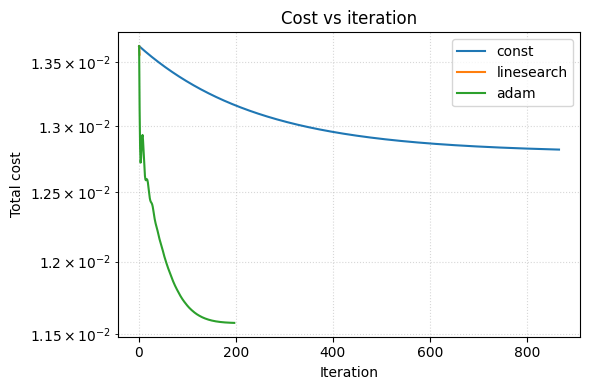

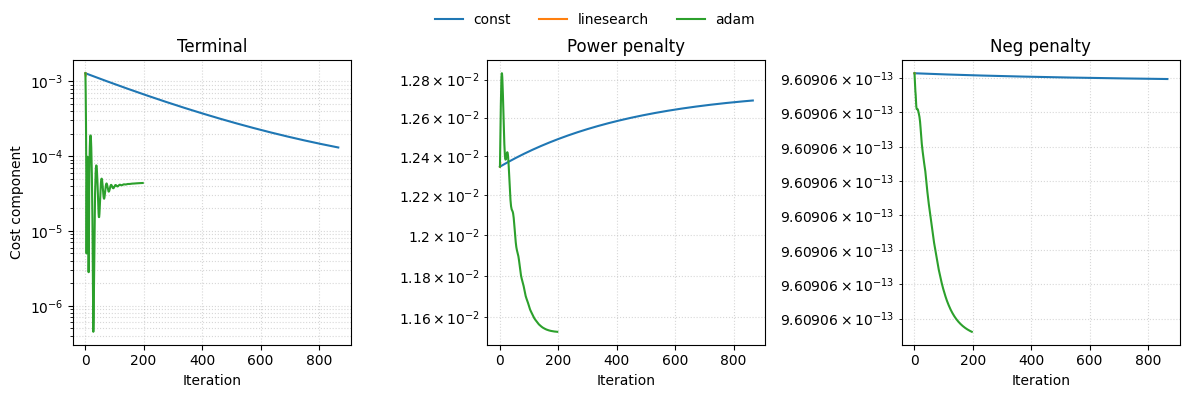

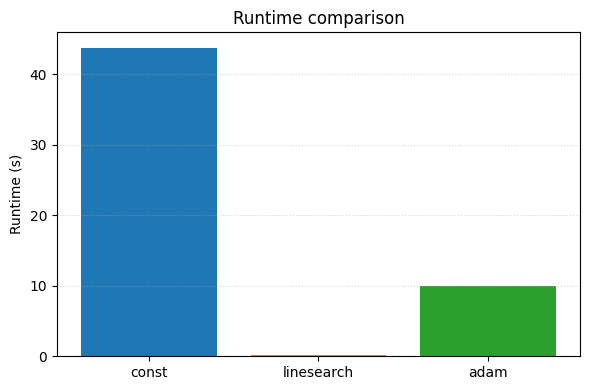

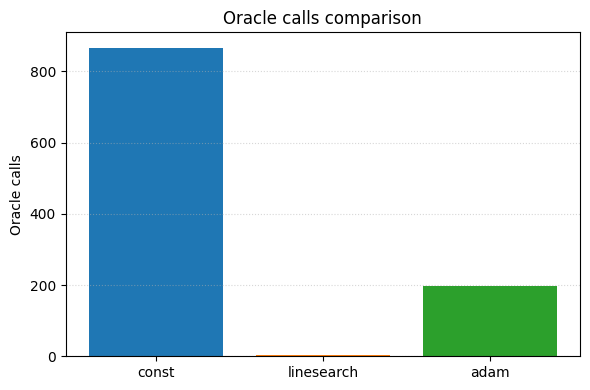

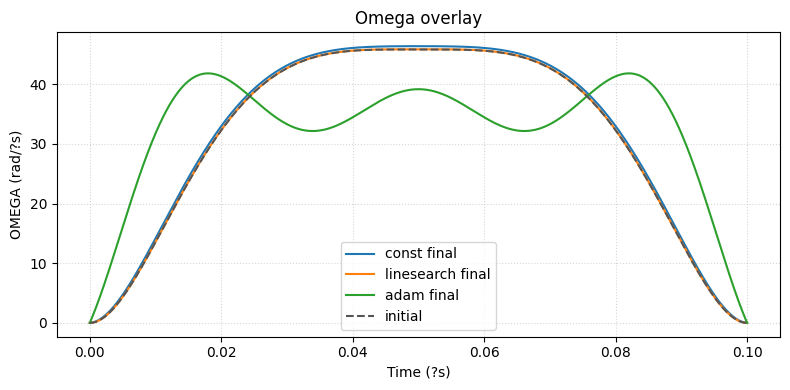

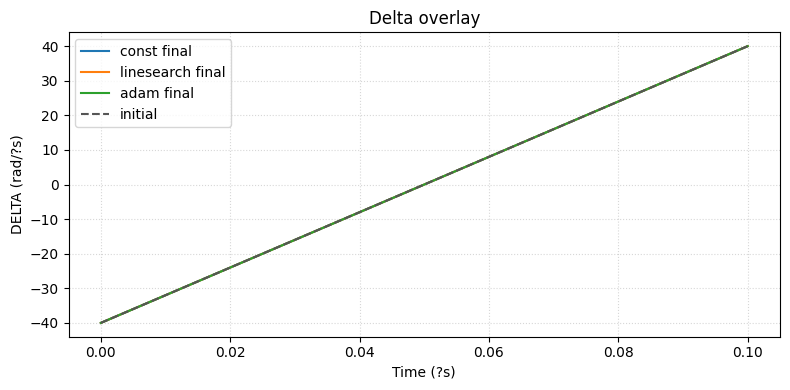

ValueError: x and y must have same first dimension, but have shapes (2001,) and (2002,)

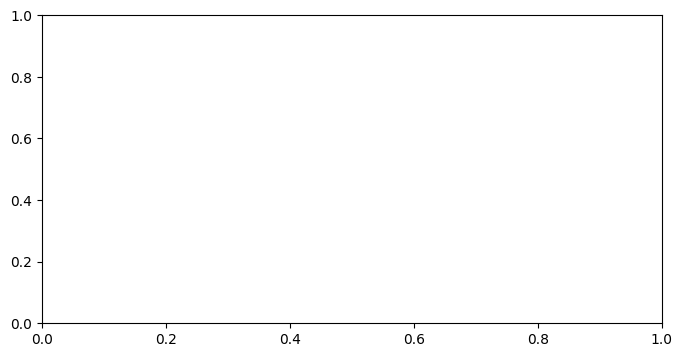

In [7]:

# Render & save all figures
fig_dir = ensure_fig_dir()
results = ensure_results_loaded()
paths = []
paths.append(plot_cost_vs_iter(results, fig_dir))
paths.append(plot_cost_terms_vs_iter(results, fig_dir))
paths.append(plot_runtime_bars(results, fig_dir))
paths.append(plot_oracle_calls_bars(results, fig_dir))
paths.append(plot_pulses_overlay(results, "omega", fig_dir))
paths.append(plot_pulses_overlay(results, "delta", fig_dir))
ensure_trajectories(results)
paths.append(plot_population_vs_time(results, fig_dir))
paths.append(plot_bloch_trajectories(results, fig_dir))
saved = [p for p in paths if p is not None]
print("Saved figures:")
for p in saved:
    print(f" - {p}")
